In [30]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [31]:
# Load dataset
df = pd.read_csv('test-data/2015_to_2022_dataset.csv')

In [32]:
# Replace missing values with NaN
df.replace("", np.nan, inplace=True)

In [34]:
df.isnull().sum()

Code                         0
Locale                       0
Date                         0
Temperature                  7
Precipitation            63134
Wind_Speed                  55
Wind_Direction              68
Humidity                    35
Vapor_Pressure               7
Dew_Point_Temperature       10
Spot_Atm_Pressure           21
Sea_Level_Pressure          17
Daylight_Time            32027
Insolation               31852
Snowfall_Amount          68051
Clouds_Amount             7111
Ground_Temperature          67
SO2                       1486
CO                        2672
NO2                       2074
PM10                      1436
PM2_5                     1330
O3                        1397
dtype: int64

In [35]:
df[df['Temperature'].isnull()]
df[df['Precipitation'].isnull()]
df[df['Wind_Speed'].isnull()]
df[df['Wind_Direction'].isnull()]
df[df['Dew_Point_Temperature'].isnull()]
df[df['Spot_Atm_Pressure'].isnull()]
df[df['Daylight_Time'].isnull()]
df[df['Insolation'].isnull()]
df[df['Snowfall_Amount'].isnull()]
df[df['Clouds_Amount'].isnull()]
df[df['Ground_Temperature'].isnull()]
df[df['SO2'].isnull()]
df[df['CO'].isnull()]
df[df['NO2'].isnull()]
df[df['PM10'].isnull()]
df[df['PM2_5'].isnull()]
df[df['O3'].isnull()]



,Code,Locale,Date,Temperature,Precipitation,Wind_Speed,Wind_Direction,Humidity,Vapor_Pressure,Dew_Point_Temperature,...,Insolation,Snowfall_Amount,Clouds_Amount,Ground_Temperature,SO2,CO,NO2,PM10,PM2_5,O3
108,108,Seoul,2015-01-05 12:00,6.0,NaN,3.1,70.0,60.0,5.6,-1.1,...,1.37,NaN,5.0,2.1,NaN,NaN,NaN,NaN,NaN,NaN
109,108,Seoul,2015-01-05 13:00,6.2,NaN,3.6,70.0,60.0,5.7,-1.0,...,0.92,NaN,8.0,3.5,NaN,NaN,NaN,NaN,NaN,NaN
612,108,Seoul,2015-01-26 12:00,5.1,NaN,1.8,270.0,99.0,8.7,4.9,...,0.30,NaN,NaN,4.2,NaN,NaN,NaN,NaN,NaN,NaN
613,108,Seoul,2015-01-26 13:00,5.4,NaN,4.0,290.0,93.0,8.3,4.3,...,0.42,NaN,NaN,5.1,NaN,NaN,NaN,NaN,NaN,NaN
638,108,Seoul,2015-01-27 14:00,-0.8,NaN,4.4,270.0,40.0,2.3,-12.7,...,1.91,NaN,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69353,108,Seoul,2022-11-29 17:00,5.3,NaN,3.5,250.0,45.0,4.0,-5.6,...,0.20,NaN,8.0,5.7,NaN,NaN,NaN,NaN,NaN,NaN
69758,108,Seoul,2022-12-16 14:00,-2.7,NaN,2.7,290.0,39.0,2.0,-14.7,...,1.79,1.9,3.0,0.4,NaN,NaN,NaN,NaN,NaN,NaN
69759,108,Seoul,2022-12-16 15:00,-2.3,NaN,2.7,270.0,37.0,1.9,-15.0,...,1.35,1.8,2.0,-0.1,NaN,NaN,NaN,NaN,NaN,NaN
70069,108,Seoul,2022-12-29 13:00,-0.2,NaN,2.3,290.0,36.0,2.2,-13.5,...,1.92,NaN,0.0,4.1,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Define the columns to be imputed with the median
median_columns = [
    'Temperature', 'Wind_Speed', 'Wind_Direction', 'Humidity',
    'Vapor_Pressure', 'Dew_Point_Temperature', 'Spot_Atm_Pressure',
    'Sea_Level_Pressure', 'SO2', 'CO', 'NO2', 'PM10', 'PM2_5', 'O3',
    'Ground_Temperature'
]

# Define the columns to be imputed with zero
zeroing_columns = [
    'Precipitation', 'Daylight_Time', 'Insolation',
    'Snowfall_Amount', 'Clouds_Amount'
]


In [37]:
# Create imputer for median
imputer_median = SimpleImputer(strategy='median')

In [38]:
# Apply the imputer to the columns that require the median
df[median_columns] = imputer_median.fit_transform(df[median_columns])

In [39]:
# Fill the NaN values with zero for the columns that require zeroing
df[zeroing_columns] = df[zeroing_columns].fillna(0)

In [40]:
# Check if there are any remaining NaN values
print(df.isnull().sum())

Code                     0
Locale                   0
Date                     0
Temperature              0
Precipitation            0
Wind_Speed               0
Wind_Direction           0
Humidity                 0
Vapor_Pressure           0
Dew_Point_Temperature    0
Spot_Atm_Pressure        0
Sea_Level_Pressure       0
Daylight_Time            0
Insolation               0
Snowfall_Amount          0
Clouds_Amount            0
Ground_Temperature       0
SO2                      0
CO                       0
NO2                      0
PM10                     0
PM2_5                    0
O3                       0
dtype: int64


In [41]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%y%m%d%H')
df['Date'] = df['Date'].astype(int)

In [42]:
df = df.drop(columns = ['Code', 'Locale'])

In [43]:
# Compute pairwise correlation of columns
correlation_matrix = df.corr()

In [44]:
# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


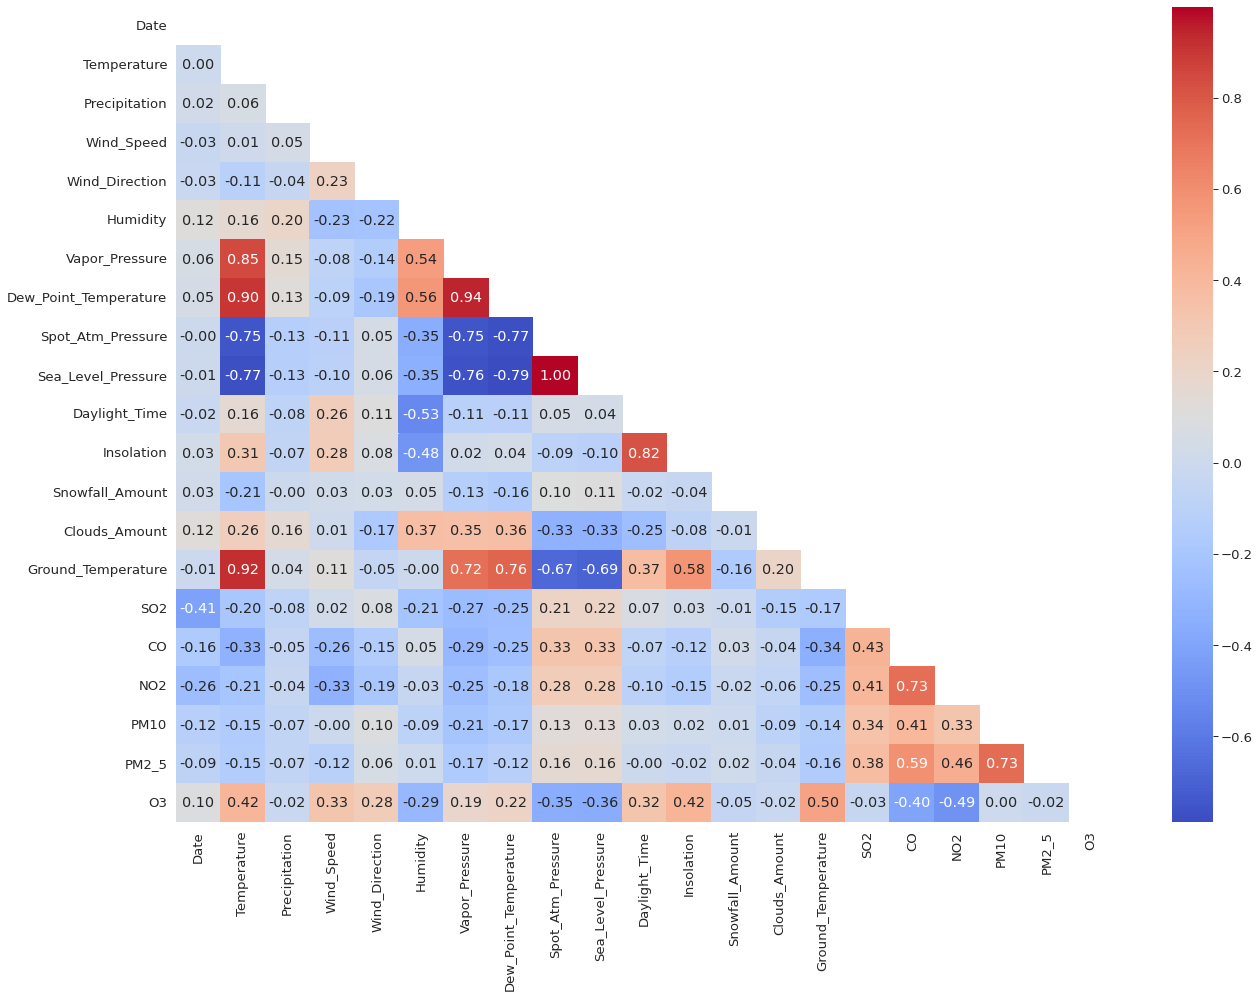

In [45]:
# Draw the heatmap with the mask
plt.figure(figsize=(21, 15))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [46]:
# Set correlation threshold
threshold = 0.8

# Find pairs of features that have a correlation higher than the threshold
highly_correlated_features = [(column1, column2) for column1 in correlation_matrix.columns 
                              for column2 in correlation_matrix.columns 
                              if (column1 != column2) and (abs(correlation_matrix[column1][column2]) > threshold)]


In [47]:
# Print highly correlated feature pairs
for pair in highly_correlated_features:
    print(pair)

('Temperature', 'Vapor_Pressure')
('Temperature', 'Dew_Point_Temperature')
('Temperature', 'Ground_Temperature')
('Vapor_Pressure', 'Temperature')
('Vapor_Pressure', 'Dew_Point_Temperature')
('Dew_Point_Temperature', 'Temperature')
('Dew_Point_Temperature', 'Vapor_Pressure')
('Spot_Atm_Pressure', 'Sea_Level_Pressure')
('Sea_Level_Pressure', 'Spot_Atm_Pressure')
('Daylight_Time', 'Insolation')
('Insolation', 'Daylight_Time')
('Ground_Temperature', 'Temperature')


In [48]:
# Calculate covariance
covariance = df.cov()['O3']
# Calculate correlation
correlation = df.corr()['O3']
# Calculate p-value
p_values = {column: pearsonr(df[column], df['O3'])[1] for column in df.columns if df[column].dtype != 'object' and column != 'O3'}

# The p-value can be used to test the hypothesis that the correlation is zero. 
# A small p-value (typically ≤ 0.05) indicates strong evidence that the correlation is significant.
# Remember that correlation measures the linear relationship between two variables, and it might not capture non-linear relationships. 
# Also, a low p-value indicates that there is evidence to reject the null hypothesis that the correlation is zero, but it doesn't quantify the magnitude or the importance of the correlation.

In [49]:
print("Covariance with O3:\n", covariance)
print("\nCorrelation with O3:\n", correlation)
print("\nP-values:\n", p_values)

Covariance with O3:
 Date                     4232.200528
Temperature                 0.088377
Precipitation              -0.000529
Wind_Speed                  0.007594
Wind_Direction              0.587145
Humidity                   -0.109863
Vapor_Pressure              0.030994
Dew_Point_Temperature       0.051313
Spot_Atm_Pressure          -0.054696
Sea_Level_Pressure         -0.058742
Daylight_Time               0.002595
Insolation                  0.006879
Snowfall_Amount            -0.000350
Clouds_Amount              -0.001919
Ground_Temperature          0.127872
SO2                        -0.000001
CO                         -0.001660
NO2                        -0.000154
PM10                        0.001609
PM2_5                      -0.005644
O3                          0.000367
Name: O3, dtype: float64

Correlation with O3:
 Date                     0.096357
Temperature              0.417487
Precipitation           -0.023143
Wind_Speed               0.325635
Wind_Direction    

<AxesSubplot:>

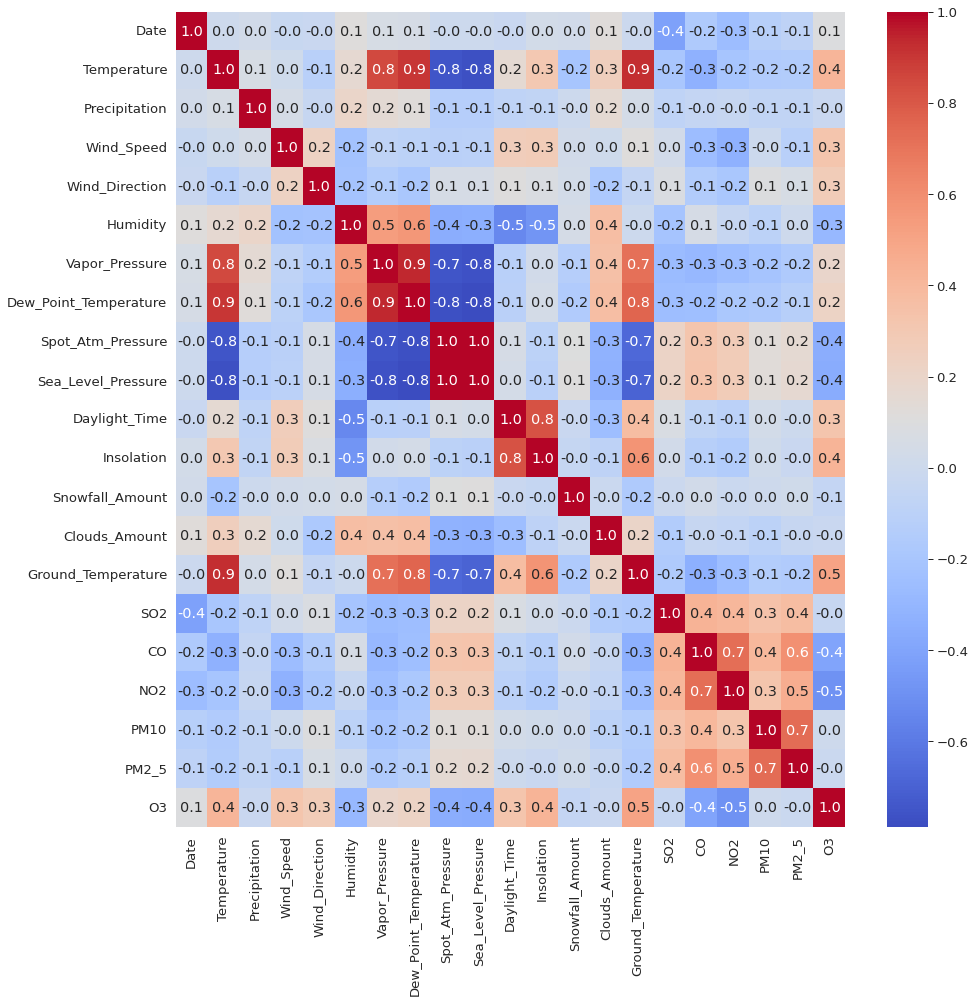

In [50]:
corr = df.corr()

sns.set_style('whitegrid')

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(15, 15)) 
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.1f')

In [22]:
# Specify the target variable
y = df['O3']

In [23]:
# Specify the feature variables
X = df.drop(['Date', 'Code', 'Locale', 'O3'], axis=1)

In [24]:
# Feature Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [152]:
# Define the hyperparameters grid
param_grid_developed = {
    'C': [0.1, 1, 10, 100, 1000],
    'epsilon': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'degree': [2, 3, 4, 5],
    'coef0': [0, 0.1, 0.5, 1, 10]
}

In [26]:
# Define the hyperparameters grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

In [27]:
# Initialize SVR
svr = SVR()

In [28]:
# Initialize GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error',n_jobs=-1, verbose=2)

In [29]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


KeyboardInterrupt: 

In [26]:
# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'}


In [27]:
# Initialize SVR with the best parameters
model = grid_search.best_estimator_

In [28]:
# Fit the model
model.fit(X_train, y_train)

SVR(C=0.1, epsilon=0.01)

In [29]:
# Make predictions
predictions = model.predict(X_test)

In [30]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 0.008477


In [31]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print("MAE: %f" % (mae))

MAE: 0.006747


In [32]:
# Calculate R2 Score
r2 = r2_score(y_test, predictions)
print("R2 Score: %f" % (r2))

R2 Score: 0.594951


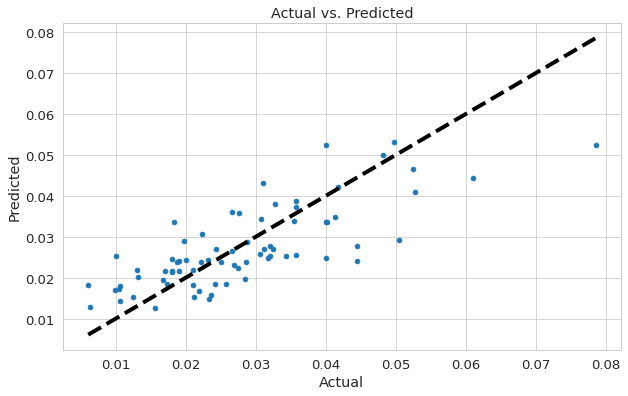

In [33]:
# Plot Actual vs. Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

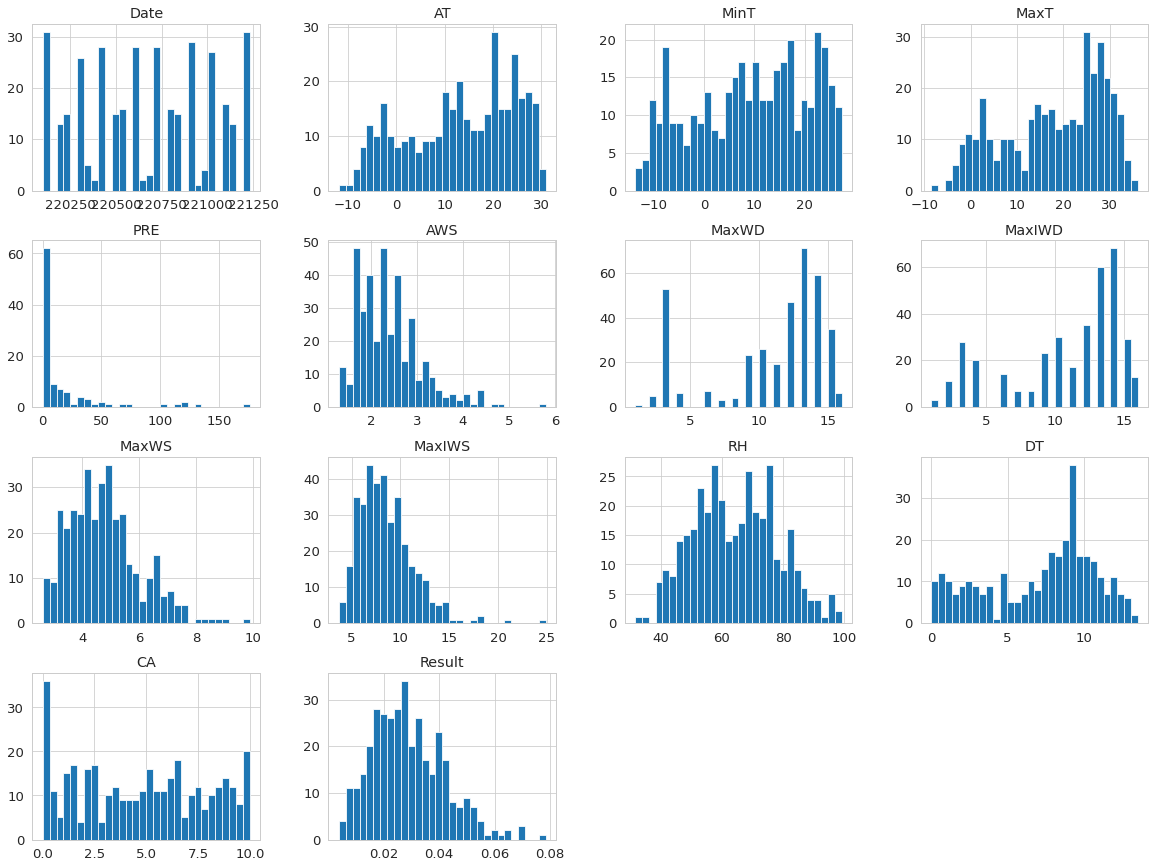

In [34]:
# Histograms for each variable in your dataset
df.hist(bins=30, figsize=(20,15))
plt.show()

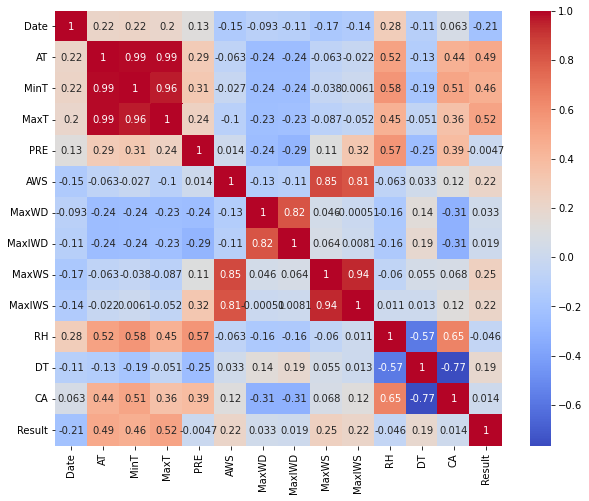

In [ ]:
# Heatmap of Correlations
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

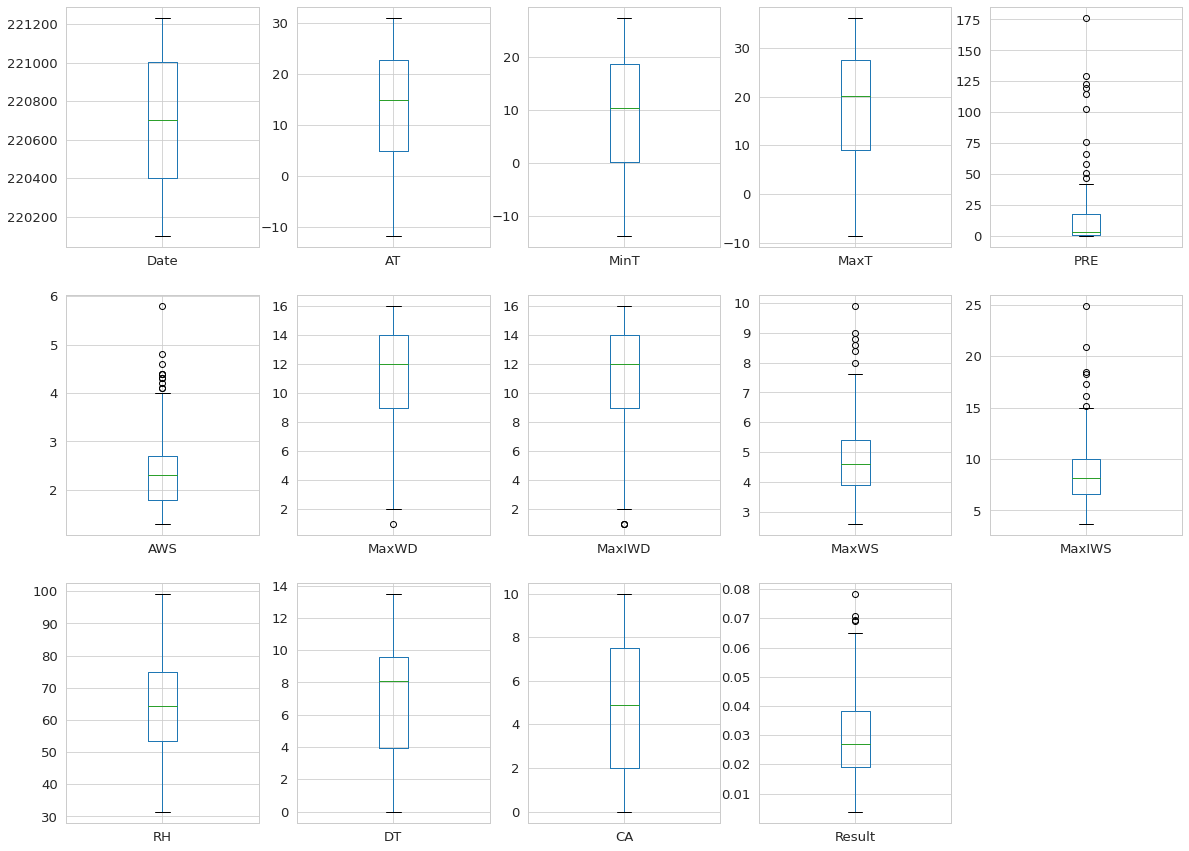

In [35]:
# Box plots for each variable
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 5, i)
    df.boxplot(column)
plt.show()